In [194]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [195]:
device = torch.device("mps" if torch.has_mps else "cpu")

device

/var/folders/8y/qyq16t6549scb0wwphs6rhjm0000gn/T/ipykernel_17623/1362845970.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")


device(type='mps')

In [196]:
data = pd.read_csv('./Google_Stock_Price_Train-1.csv')

data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [197]:
data.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [199]:
data['Date'] = pd.to_datetime(data['Date'])
data['Volume'] = data['Volume'].str.replace(',', '').astype(float)
data['Close'] = data['Close'].str.replace(',', '').astype(float)

In [ ]:
close_prices = data[['Close']]
scaler = MinMaxScaler(feature_range=(0.1, 0.9))
scaled_data = scaler.fit_transform(close_prices)

In [201]:
features = data[['Open', 'High', 'Low', 'Volume', 'Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 120
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [205]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
class StockPriceGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StockPriceGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru1(x)
        out = self.dropout(out)
        out, _ = self.gru2(out)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_size = 1
hidden_size = 100
output_size = 1

In [208]:
model = StockPriceGRU(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [ ]:
epochs = 200
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()

    scheduler.step()

    if (epoch + 1) % 20 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train)
            train_rmse = np.sqrt(criterion(train_predictions, y_train.view(-1, 1)).item())
            test_predictions = model(X_test)
            test_rmse = np.sqrt(criterion(test_predictions, y_test.view(-1, 1)).item())
        print(f"Epoch {epoch+1}/{epochs}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 20/200, Train RMSE: 0.0171, Test RMSE: 0.0193
Epoch 40/200, Train RMSE: 0.0173, Test RMSE: 0.0209
Epoch 60/200, Train RMSE: 0.0255, Test RMSE: 0.0288
Epoch 80/200, Train RMSE: 0.0172, Test RMSE: 0.0197
Epoch 100/200, Train RMSE: 0.0200, Test RMSE: 0.0268
Epoch 120/200, Train RMSE: 0.0217, Test RMSE: 0.0420
Epoch 140/200, Train RMSE: 0.0165, Test RMSE: 0.0193
Epoch 160/200, Train RMSE: 0.0163, Test RMSE: 0.0186
Epoch 180/200, Train RMSE: 0.0196, Test RMSE: 0.0350
Epoch 200/200, Train RMSE: 0.0168, Test RMSE: 0.0246


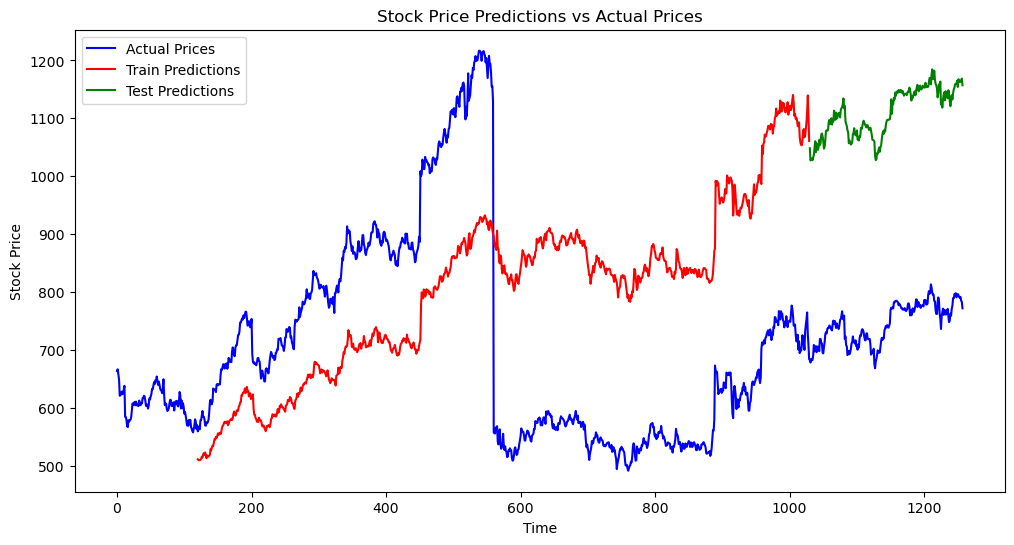

In [ ]:
timeseries = close_prices['Close'].values
train_size = len(y_train)

train_plot = np.ones_like(timeseries) * np.nan
test_plot = np.ones_like(timeseries) * np.nan

with torch.no_grad():
    train_predictions = model(X_train).cpu().numpy().flatten()
    train_plot[sequence_length:train_size + sequence_length] = scaler.inverse_transform(
        np.concatenate([
            np.zeros((train_predictions.shape[0], scaled_data.shape[1] - 1)),
            train_predictions.reshape(-1, 1)
        ], axis=1)
    )[:, -1]

    test_predictions = model(X_test).cpu().numpy().flatten()
    test_plot[train_size + sequence_length:] = scaler.inverse_transform(
        np.concatenate([
            np.zeros((test_predictions.shape[0], scaled_data.shape[1] - 1)),
            test_predictions.reshape(-1, 1)
        ], axis=1)
    )[:, -1]

plt.figure(figsize=(12, 6))
plt.plot(timeseries, label="Actual Prices", color='blue')
plt.plot(train_plot, label="Train Predictions", color='red')
plt.plot(test_plot, label="Test Predictions", color='green')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Predictions vs Actual Prices")
plt.show()

* Train RMSE: Stable around 0.016–0.017, indicating consistent training.
* Test RMSE: Varies slightly, with occasional increases up to 0.042, suggesting some sensitivity or overfitting.

The model effectively captures the general trend of the stock prices but consistently underpredicts actual values, resulting in predictions that are parallel to but lower than the actual prices.